In [1]:
"""
File: tng_images.py
Author: Matthew Ogden
Email: ogdenm12@gmail.com
Github: mbogden
Created: 2024-Apr-02

Description: 
    This code is designed to pull particle data from the IllustrisTNG Simulation Particles. 
    And visualize if a variety of ways for future use. 

References:  
- TNG50 Simulation Data
    - Nelson, D. et al. (2015). The Illustris Simulation: Public Data Release. Astronomy and Computing, 13, 12–37. https://doi.org/10.1016/j.ascom.2015.09.003
    - Nelson, D. et al. (2019). First results from the TNG50 simulation: Galactic outflows driven by supernovae and black hole feedback. Monthly Notices of the Royal Astronomical Society, 490(3), 3234–3261. https://doi.org/10.1093/mnras/stz2306
    - Pillepich, A. et al. (2019). First results from the TNG50 simulation: The evolution of stellar and gaseous discs across cosmic time. Monthly Notices of the Royal Astronomical Society, 490(3), 3196–3233. https://doi.org/10.1093/mnras/stz2338

Acknowledgements:    
- Sections of this code were written with the assistance of ChatGPT made by OpenAI.

"""


'\nFile: tng_images.py\nAuthor: Matthew Ogden\nEmail: ogdenm12@gmail.com\nGithub: mbogden\nCreated: 2024-Apr-02\n\nDescription: \n    This code is designed to pull particle data from the IllustrisTNG Simulation Particles. \n    And visualize if a variety of ways for future use. \n\nReferences:  \n- TNG50 Simulation Data\n    - Nelson, D. et al. (2015). The Illustris Simulation: Public Data Release. Astronomy and Computing, 13, 12–37. https://doi.org/10.1016/j.ascom.2015.09.003\n    - Nelson, D. et al. (2019). First results from the TNG50 simulation: Galactic outflows driven by supernovae and black hole feedback. Monthly Notices of the Royal Astronomical Society, 490(3), 3234–3261. https://doi.org/10.1093/mnras/stz2306\n    - Pillepich, A. et al. (2019). First results from the TNG50 simulation: The evolution of stellar and gaseous discs across cosmic time. Monthly Notices of the Royal Astronomical Society, 490(3), 3196–3233. https://doi.org/10.1093/mnras/stz2338\n\nAcknowledgements:    

In [2]:
# ================================ IMPORTS ================================ #
import os, argparse
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec 


# Illustris TNG import
import illustris_python as il
import tng_functions as tf
import tng_particles as tp # particle_module

print("Imports Done")

# Global variables
SIM_DIR = '../sims.TNG/TNG50-1/output/'

# Am I currently writing this code?
buildEnv = True

Imports Done
Args: Defined
Imports Done


In [3]:
# ================================ INPUT ARGUMENTS ================================ #

# Define argument parser function 
def initParser():
    
    parser = argparse.ArgumentParser()
    
    # Simulation Arguments
    parser.add_argument( '-s', '--simDir', default = '/home/tnguser/sims.TNG/TNG50-1/output',  type=str, \
                        help="Base directory for a single simulation on the IllustrisTNG servers.")   
    
    parser.add_argument( '-n', '--simName', default = 'TNG50-1',  type=str, \
                        help="Name for the simulation being worked on.")    

    # Function arguments
    parser.add_argument( '-f', '--function', default = 'None', type=str, \
                        help="Unqiue functions this program can execute from command line.")
    
    parser.add_argument( '-d', '--dataDir', default = 'data', type=str, \
                        help="Default location to store misc data files.")
    
    parser.add_argument('-ow', '--overwrite', action='store_true',
                        help="Overwrite output files? \
                        If false, will check if output file exists before beginning time-consuming tasks.")
    
    parser.add_argument( '-i', '--inputFile', type=str, \
                        help="Input file location.")
    
    parser.add_argument( '-o', '--outputFile', type=str, \
                        help="Output file location.")
    
    return parser

parser = initParser()
script_args = parser.parse_args()
print("Args: Defined")

Args: Defined


In [58]:
if buildEnv and True:
    
    m_loc = 'tng-data/moi_4-test-dynamics.pkl'
    assert os.path.exists( m_loc ), f'Target information file not found: {m4_loc}'
    print(f"Reading: {m_loc}")
    
    # Read potential tng targets file
    m_df = pd.read_pickle( m_loc )
    print( f"ALL MOI_4 Shape {m_df.shape}")
    print( f"Columns: {m_df.columns}" )
    
    t_df = m_df[ m_df['moi_4'] == True ]
    t_df.info()
    t_row = m_df[ m_df['p_SubhaloIDRaw'] == 62000000190717 ].iloc[0]
    print( t_row )

        

Reading: tng-data/moi_4-test-dynamics.pkl
ALL MOI_4 Shape (102, 71)
Columns: Index(['moi_2', 'snap', 'merger_snap', 'p_moi_1', 's_moi_1', 'xy_projection',
       'p_face_projection', 's_face_projection', 'p_SubhaloID', 's_SubhaloID',
       'p_NextProgenitorID', 's_NextProgenitorID', 'p_MainLeafProgenitorID',
       's_MainLeafProgenitorID', 'p_FirstProgenitorID', 's_FirstProgenitorID',
       'p_SubhaloGrNr', 's_SubhaloGrNr', 'p_SubhaloIDRaw', 's_SubhaloIDRaw',
       'p_SubhaloMass', 's_SubhaloMass', 'p_RootDescendantID',
       's_RootDescendantID', 'p_SnapNum', 's_SnapNum', 'p_DescendantID',
       's_DescendantID', 'p_SubhaloPos', 's_SubhaloPos', 'p_SubhaloVel',
       's_SubhaloVel', 'p_SubhaloSpin', 's_SubhaloSpin',
       'p_SubhaloHalfmassRad', 's_SubhaloHalfmassRad', 'p_SubhaloCM',
       's_SubhaloCM', 'moi_4', 'p_inclination', 'p_azimuthal', 's_inclination',
       's_azimuthal', 'pa_SubhaloMass', 'pa_SubhaloCM', 'pa_SubhaloVel',
       'pa_SubhaloSpin', 'pa_SubhaloHalfmass

In [43]:
def get_coordinate_pts( t_row ):
    
    _, pid = tf.deconstruct_subhalo_id_raw( t_row['p_SubhaloIDRaw']  )
    _, sid = tf.deconstruct_subhalo_id_raw( t_row['s_SubhaloIDRaw']  )
    snap = t_row['snap']    
    
    p_pts = il.snapshot.loadSubhalo('/home/tnguser/sims.TNG/TNG50-1/output', 
                            snap, pid, 4, fields=['Coordinates'])
    
    s_pts = il.snapshot.loadSubhalo('/home/tnguser/sims.TNG/TNG50-1/output', 
                            snap, sid, 4, fields=['Coordinates'])
    
    pts = np.vstack([p_pts, s_pts])
    p_id = np.zeros(p_pts.shape[0])
    s_id = np.ones(s_pts.shape[0])
    subhalo_id = np.hstack([p_id, s_id])
    
    print( pts.shape, subhalo_id.shape )
    pts = np.hstack( [ pts, subhalo_id.reshape(-1,1)])
    
    return pts
    

if buildEnv and True:
    
    pts = get_coordinate_pts( t_row )
    print('Pts!:', pts.shape )
    

(1519823, 3) (1519823,)
Pts!: (1519823, 4)


# Simple Histogram

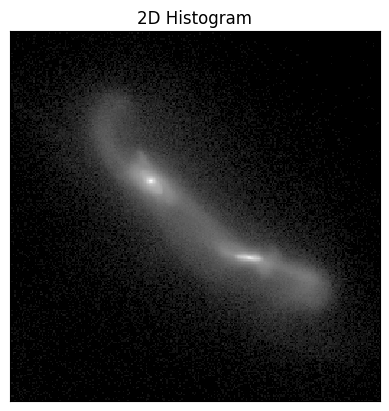

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def xy_histogram( xy_data, ax=None,  title="2D Histogram", std_dev=5, bins=256, cmap='gray', log_scale=True):
    """
    Plots a 2D histogram on a given axis with x and y limits set to n standard deviations.

    Args:
    ax (matplotlib.axes.Axes or None): The axis to plot on. If None, a new figure and axis will be created.
    xy_data (np.ndarray): An N x 2 array of xy coordinates.
    title (str): Title of the subplot.
    std_dev (float): Number of standard deviations to set axis limits.
    bins (int): Number of bins along each axis in the histogram.
    cmap (str): Colormap for the histogram.
    log_scale (bool): Whether to apply logarithmic scaling to the histogram.
    """
    if xy_data is None:
        raise ValueError("xy_data cannot be None")

    # If ax is None, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    # Calculate the mean and standard deviation
    mean_xy = np.mean(xy_data[:, 0:2], axis=0)
    std_xy = np.std(xy_data[:, 0:2], axis=0)

    # Determine the maximum range to use for both axes
    max_range = np.max(std_xy) * std_dev

    # Set axis limits to be the same for both x and y
    xlim = (mean_xy[0] - max_range, mean_xy[0] + max_range)
    ylim = (mean_xy[1] - max_range, mean_xy[1] + max_range)

    # Create the histogram
    h, xedges, yedges, image = ax.hist2d(xy_data[:, 0], xy_data[:, 1], bins=bins, range=[xlim, ylim], cmap=cmap)

    if log_scale:
        h = np.log1p(h)  # Apply log1p to enhance visibility of low count regions

    # Clear the axis and plot with modified histogram data
    ax.clear()
    image = ax.imshow(h.T, interpolation='nearest', origin='lower', aspect='auto',
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                      cmap=cmap)
    
    # Set titles and labels
    ax.set_title(title)
    
    # Remove the axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')

    # If ax was None, display the plot
    if ax is None:
        plt.show()

if buildEnv:
    xy_histogram( pts, log_scale = True, std_dev = 3 )
    

# POV:  Let's change the angle being plotted.

## (FAILED) Stellar Photometrics

It turns out, the test target I was using for my sample, happened to land on a full snapshot.  Thus I loaded the star photometrics and created realistic images via actual wavelenths.  However, the mini snapshots don't have this value so I probably won't be using this for my image creation.... sadly.  But perhaps for a few targets later on once I actually go through all the images to identify tidal features.

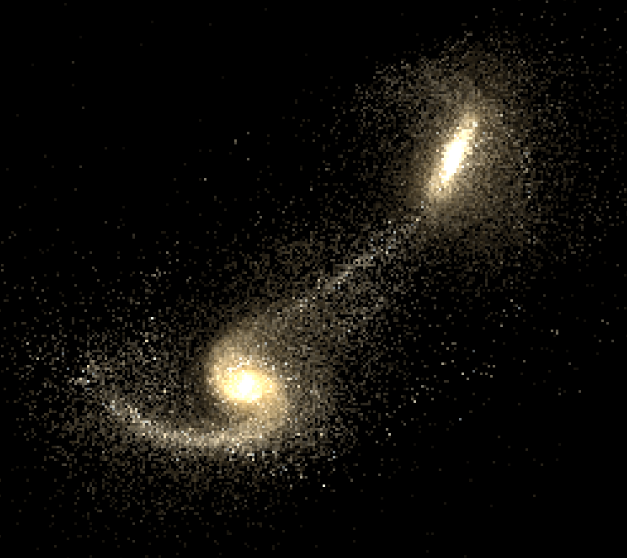


In [53]:
if buildEnv and False:
    # id1, id2, 
    img_size = (128,128), 
    std_dev = 3
    
    for i, row in m_df.iterrows():
        
        # Skip rows without tidal features
        # if row['moi_4'] == False:  continue
        
        
        _, pid = tf.deconstruct_subhalo_id_raw( row['p_SubhaloIDRaw'] )
        _, sid = tf.deconstruct_subhalo_id_raw( row['s_SubhaloIDRaw'] )
        snap = row['snap']
        
        if snap not in ( 99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21 ): 
            continue
        print( i, snap, pid, sid, '      ')
        
        
        # if row['moi_4'] == False:  continue
        
        p_pts = il.snapshot.loadSubhalo( script_args.simDir, snap, pid, 4)
        s_pts = il.snapshot.loadSubhalo( script_args.simDir, snap, sid, 4)
        
        if p_pts.get( 'GFM_StellarPhotometrics', None ) is None or s_pts.get( 'GFM_StellarPhotometrics', None ) is None:
            m_df.at[i,'valid_photometrics'] = False
        else:
            m_df.at[i,'valid_photometrics'] = True
        

    print( m_df['valid_photometrics'] )
        

#     # Standardize array for coordinates and IRG bands
#     n = tmp_pts1['stars']['Coordinates'].shape[0] + tmp_pts2['stars']['Coordinates'].shape[0]
#     m = tmp_pts1['stars']['Coordinates'].shape[0]
    
#     raw_ar = np.zeros((n, 6))
    
#     # Save coordinates
#     raw_ar[:m, 0:3] = tmp_pts1['stars']['Coordinates']
#     raw_ar[m:, 0:3] = tmp_pts2['stars']['Coordinates']   
    
#     # Save RGB values from the photometric bands
#     # Stellar magnitudes in eight bands: U, B, V, K, g, r, i, z
#     raw_ar[:m, 3:6] = tmp_pts1['stars']['GFM_StellarPhotometrics'][:, [6, 5, 4]] # i, r, g bands
#     raw_ar[m:, 3:6] = tmp_pts2['stars']['GFM_StellarPhotometrics'][:, [6, 5, 4]] # i, r, g bands

In [54]:
def plot_igr_histograms(photometrics, bins=50, range=(-14, 0)):
    """
    Plots histograms for the i, g, and r bands from photometric data.

    Args:
    photometrics (np.ndarray): An N x 3 array where columns are i, g, r band values.
    bins (int): Number of bins in the histogram.
    range (tuple): The lower and upper range of the bins.
    """
    # Ensure that photometrics has three columns (i, g, r)
    assert photometrics.shape[1] == 3, "Photometrics array should have three columns for i, g, r bands."

    i_band = photometrics[:, 0]
    g_band = photometrics[:, 1]
    r_band = photometrics[:, 2]

    # Creating the histogram
    plt.figure(figsize=(12, 8))

    # Plotting i-band
    plt.hist(i_band, bins=bins, range=range, alpha=0.7, label='i-band', color='purple')

    # Plotting g-band
    plt.hist(g_band, bins=bins, range=range, alpha=0.7, label='g-band', color='green')

    # Plotting r-band
    plt.hist(r_band, bins=bins, range=range, alpha=0.7, label='r-band', color='red')

    # Adding titles and labels
    plt.title('Distribution of Stellar Photometrics in i, g, r Bands')
    plt.xlabel('Magnitude')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage
if buildEnv and False:
    # Example photometric data: 1000 particles, 3 bands (i, g, r)
    #example_data = np.random.uniform(-14, 0, size=(1000, 3))  # Generating random data for demonstration
    plot_igr_histograms(raw_ar[:,3:6])


In [55]:
def convert_magnitude_to_flux(raw_photometrics):
    # Converts magnitudes in vis_ar[:, 3:6] to flux
    # raw_ar[:, 3:6] should contain i, r, g bands magnitudes
    flux = 10 ** (-0.4 * (raw_photometrics[:] + 48.6))  # including a zero-point
    
    # Normalize the flux values to the range [0, 1]
    max_flux = np.max(flux, axis=0)  # Max for each band
    norm_flux = flux / max_flux
    return norm_flux

def create_rgb_image(vis_ar, image_size=np.array([128, 128]), pixel_scale=1.0, n_std_devs=3):
    # Calculate mean and standard deviation for x and y
    means = np.mean(vis_ar[:, :2], axis=0)
    std_devs = np.std(vis_ar[:, :2], axis=0)

    # Create a mask for particles within the specified standard deviation
    within_std_dev_mask = np.all(np.abs(vis_ar[:, :2] - means) < (n_std_devs * std_devs), axis=1)

    # Apply the mask
    vis_ar = vis_ar[within_std_dev_mask]

    # Initialize an empty RGB image
    rgb_image = np.zeros((image_size[0], image_size[1], 3))
    
    # Scale the coordinates to fit within the image size
    min_coords = np.min(vis_ar[:, :2], axis=0)
    max_coords = np.max(vis_ar[:, :2], axis=0)
    scale = (image_size - 1) / (max_coords - min_coords)
    pixel_coords = (vis_ar[:, :2] - min_coords) * scale.astype(np.float64)

    # Convert pixel coordinates to integers
    pixel_coords = pixel_coords.astype(int)

    # Add the star fluxes to the corresponding pixels in the RGB image
    for (x, y), fluxes in zip(pixel_coords, vis_ar[:, 3:6]):
        rgb_image[y, x] += fluxes  # Add fluxes to the red, green, and blue channels

    # Apply gamma correction
    gamma_corrected_image = np.power(rgb_image.clip(0, 1), 1/2.2)  # Gamma correction for display

    return gamma_corrected_image

# Use these functions to process the visibility array and create an image
if buildEnv and False:
    
    # Copy coordinates
    vis_ar = np.zeros( raw_ar.shape )
    vis_ar[:,0:3] = raw_ar[:,0:3]
    vis_ar[:,3:6] = convert_magnitude_to_flux( raw_ar[:,3:6] )
    rgb_image = create_rgb_image(vis_ar, image_size=np.array([256,256]))
    
    # Display the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image, origin='lower')
    plt.axis('off')  # Turn off the axis
    plt.show()


In [8]:
def normalize_vector(v):
    return v / np.linalg.norm(v)

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2 """
    a, b = normalize_vector(vec1), normalize_vector(vec2)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotate_particles(particles, spin_vector):
    # Align spin_vector with z-axis
    z_axis = np.array([0, 0, 1])
    rotation_matrix = rotation_matrix_from_vectors(spin_vector, z_axis)
    rotated_particles = particles.dot(rotation_matrix)
    return rotated_particles

# To prevent plotting extreme outlyers and reducing the primary object.
def compact_particles( pts, n_std_dev = 5 ):    
    
    # Calculate mean and standard deviation for x and y
    means = np.mean( pts[:, :2], axis=0)
    std_devs = np.std( pts[:, :2], axis=0)

    # Create a mask for particles within the specified standard deviation
    within_std_dev_mask = np.all( np.abs( pts[:, :2] - means) < (n_std_dev * std_devs), axis=1)

    # Apply the mask
    return pts[within_std_dev_mask]

def plot_galaxy_particles(subplot, particle_data, title ='' ):    
    # Plot the particles on the provided subplot
    subplot.scatter( particle_data[:, 0], particle_data[:, 1], s=1)  # Adjust size as needed
    subplot.set_title(title)
    subplot.axis('equal')  # Ensuring equal scaling on both axes

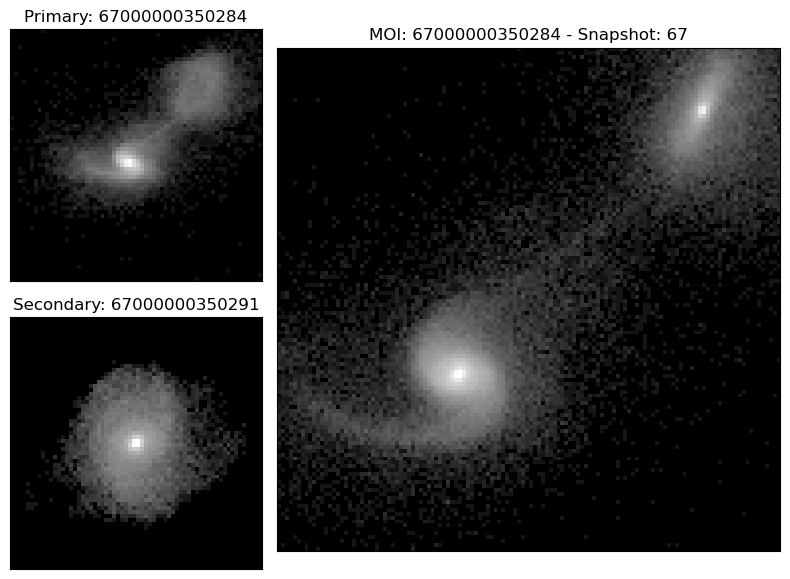

In [18]:
def simple_viz_encounter_1( enc_df, overwrite = False ):
    
    # Grab needed info
    moi_id = enc_df['moi_SubhaloIDRaw']
    snapnum = enc_df['snapnum']
    p_id = enc_df['p_SubhaloIDRaw']
    s_id = enc_df['s_SubhaloIDRaw']
    
    # Define image location
    image_loc = f"images/{moi_id}_{snapnum}.png"
    
    # If image exists, pass
    if os.path.exists( image_loc ) and not overwrite:
        print(f"Image exists: {image_loc}")
        return
    
    # Get Positions of galactic Centers
    p_pos = np.array( [ float( f ) for f in enc_df['p_SubhaloPos'][1:-1].split() ] )
    s_pos = np.array( [ float( f ) for f in enc_df['s_SubhaloPos'][1:-1].split() ] )
    
    # Get associated particles
    p_raw = pts_mod.get_subhalo_particles( p_id, get_part='stars' )
    s_raw = pts_mod.get_subhalo_particles( s_id, get_part='stars' )

    # Get coordinates from raw points
    tmp, p_pts, p_meta = pts_mod.standardize_particles( p_raw, snapnum )
    tmp, s_pts, s_meta = pts_mod.standardize_particles( s_raw, snapnum )
    
    p_dyn = pts_mod.dynamics_calculation( p_pts, snapnum )
    s_dyn = pts_mod.dynamics_calculation( s_pts, snapnum )
        
    # Down sample particles to quicken everything
    n_part = 100000    
    if p_pts.shape[0] > n_part*2:
        p_skip = int(p_pts.shape[0] / n_part)
        s_skip = int(s_pts.shape[0] / n_part)
    else:
        p_skip = 1
        s_skip = 1

    pp_pts = p_pts[::p_skip,0:3]
    sp_pts = s_pts[::s_skip,0:3]
    
    # Rotate particles to face
    p_face = compact_particles( rotate_particles( pp_pts[:,0:3], p_dyn['SubhaloSpin'] ) )
    s_face = compact_particles( rotate_particles( sp_pts[:,0:3], s_dyn['SubhaloSpin'] ) )
    t_face = np.vstack( ( pp_pts, sp_pts ) )
    
    # plot
    
    # Set up the figure and the grid spec
    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1])

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0])  # Top left subplot for primary galaxy
    ax2 = fig.add_subplot(gs[1, 0])  # Bottom left subplot for secondary galaxy
    ax3 = fig.add_subplot(gs[:, 1])  # Right subplot for combined galaxies

    # Use the plotting function
    xy_histogram(ax1, p_face, title=f"Primary: {p_id}",  )
    xy_histogram(ax2, s_face, title=f"Secondary: {s_id}", )
    xy_histogram(ax3, t_face, title=f"MOI: {moi_id} - Snapshot: {snapnum}", bins=128, std_dev=2 )
    
    # ax1.set_title('Primary Face')
    # ax2.set_title('Secondary Face')
    # ax3.set_title('Combined Galaxies')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure if needed
    plt.savefig(image_loc)

    # Show the plot
    # plt.show()    
    
def plot_particles( subplot, particle_data, title ):
    pass


if buildEnv:
    
    #row = pot_df[ pot_df['snapnum'] == 67 and pot_df['moi_SubhaloIDRaw'] == 67000000350284 ]
    
    for index, row in snapshot_info.iterrows():
    # for index, row in pot_df.iterrows():
        simple_viz_encounter( row, overwrite = True )

In [ ]:
def func_all_basic_images( args ):
    
    
    print("ALL THE IMAGES!")
    # Open up potential target information file
    pot_loc = "data/TNG50-1-moi-info-67-75.csv"    
    
    pot_df = pd.read_csv( pot_loc )
    
    # Because I'm expecting more encounter around snapshot 67.
    # Let's make those images first
    pot_df['dist_67'] = np.abs( pot_df['snapnum'].values - 67 )
    sorted_df = pot_df.sort_values( by='dist_67', ascending=True )
        
    for index, row in sorted_df.iterrows():
        try:
            simple_viz_encounter( row, overwrite = args.overwrite )
        except: 
            print(f"Failed image: {index}")
            pass

if script_args.function == 'all-images':
    func_all_basic_images( script_args )    

elif buildEnv:
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_images.py'
    cmdStr += ' --overwrite'
    cmdStr += ' --function all-images'
    
    # This function doesn't like the 'python3 file.py' part.
    build_args = parser.parse_args(cmdStr.split()[2:])
    
    if build_args.function == 'all-images':
        func_all_basic_images( build_args )
